# Linear Regression



In [49]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt 
import random

We
should
vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.
Consider two methods for adding vectors

In [4]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

We add them, one coordinate at a time,
using a for-loop

In [18]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tlk = time.time()
        
    def stop(self):
        self.times.append(time.time()-self.tlk)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times)/len(self.times)
    
    def sum(self):
        return sum(self.times)
        
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [19]:
c =torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i]= a[i]+b[i]
f'{timer.stop():.5f} sec'

'0.05897 sec'

In [20]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.05379 sec'

Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum

In [21]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00046 sec'

We define a function to compute the normal distribution

In [1]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

Visualize the normal distributions

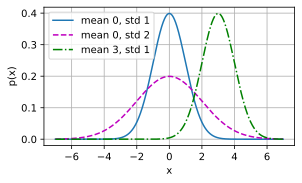

In [4]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [5]:
def synthetic_data(w,b,num_examples): #@save
    """生产y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [15]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
features.shape
labels.shape

torch.Size([1000, 1])

In [23]:
print('features:',features[0:10],'\nlable:',labels[0:10])

features: tensor([[ 0.6621, -1.1068],
        [-1.1632, -2.0606],
        [ 0.3503,  2.5026],
        [ 0.7401,  0.1655],
        [ 0.9269,  0.9072],
        [ 2.3783, -0.6104],
        [ 0.1615, -1.6170],
        [-2.9033, -0.6245],
        [ 0.9169, -0.4156],
        [ 1.5397, -0.6752]]) 
lable: tensor([[ 9.2890],
        [ 8.8767],
        [-3.6214],
        [ 5.0959],
        [ 2.9667],
        [11.0309],
        [10.0174],
        [ 0.5239],
        [ 7.4374],
        [ 9.5715]])


In [34]:
?torch.Tensor.detach

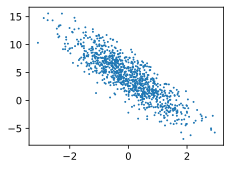

In [44]:
d2l.set_figsize()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [47]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices =list(range(num_examples))
    random.shuffle(indices) 
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
    

In [51]:
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.6464, -1.0934],
        [-0.4211, -0.1697],
        [ 0.1792,  1.5958],
        [ 0.8047, -0.0318],
        [-1.3609, -1.6878],
        [ 2.4564, -0.5185],
        [ 1.5405,  0.5496],
        [-0.7664, -0.0171],
        [-0.7023, -2.1675],
        [-1.5257,  0.3453]]) 
 tensor([[ 6.6170],
        [ 3.9297],
        [-0.8684],
        [ 5.9235],
        [ 7.2254],
        [10.8815],
        [ 5.4287],
        [ 2.7283],
        [10.1533],
        [-0.0150]])


In [56]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

tensor([0.], requires_grad=True)

In [66]:
def linreg(X,w,b): #@save
    """线性回归模型"""
    return torch.matmul(X,w)+b

In [67]:
def squared_loss(y_hat,y):  #@save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [70]:
def sgd(params,lr,batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

In [72]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_lossfeatures

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # x 和 y 的小批量损失
        # 因为l形状事(batch_size,1),而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000145
epoch 2, loss 0.000053
epoch 3, loss 0.000052


In [73]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')

w的估计误差：tensor([-7.1764e-05, -5.5552e-05], grad_fn=<SubBackward0>)


In [74]:
print(f'b的估计误差: {true_b-b}')

b的估计误差: tensor([-0.0004], grad_fn=<RsubBackward1>)
